In [1]:
import sys
import copy

import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from pushing.rl import (
    ParameterNoise,
    WelfordNormalization,
    Actor,
    Critic
)
from stitching.rl import (
    StateActionFunction,
    ReplayBuffer,
    PopTart,
    soft_update,
)

In [2]:
buffer = ReplayBuffer(int(100000))
dataloader = torch.utils.data.DataLoader(buffer, batch_size=128, shuffle=True)
env = gym.make('SimplePusher-v0')
obs = env.reset()
gamma = 0.99

INFO: Creating SimplePusher environment with rotation_x: 0.03


In [3]:
critic = Critic(env.observation_space.shape[0], env.action_space.shape[0])
critic_target = copy.deepcopy(critic)
actor = Actor(env.observation_space.shape[0], env.action_space.shape[0])
actor_target = copy.deepcopy(actor)

norm_q = PopTart()
parameter_noise = ParameterNoise(actor, 0.2)

def parameters():
    for model in [critic, norm_q]:
        for parameter in model.parameters():
            yield parameter

critic_opt = torch.optim.Adam(parameters())
actor_opt = torch.optim.Adam(actor.parameters(), weight_decay=1e-2)

logger = SummaryWriter('runs/rolling_return_save')

if torch.cuda.is_available:
    actor.cuda()
    actor_target.cuda()
    critic.cuda()
    critic_target.cuda()
    norm_q.cuda()
    parameter_noise.cuda()
    
def action_transform(u):
    """
    Transforms from [-1, 1] to [actionspace.low, actionspace.high]
    """
    u_01 = (u + 1) / 2
    action_range = (env.action_space.high - env.action_space.low)
    return u_01 * action_range + env.action_space.low

def nn_policy(obs):
    x = torch.cuda.FloatTensor(obs.reshape(1, -1))
    u = actor(x).cpu().detach().numpy().flatten()
    return u

In [4]:
nb_rollout_steps = 100
nb_epoch_cycles = 20
nb_epochs = int(1000000 / (nb_rollout_steps * nb_epoch_cycles))
nb_train_steps = 50


def rollout(policy, epsilon=0.0, render=False, fill_buffer=True, nb_rollout_steps=nb_rollout_steps):
    obs = env.reset()
    R = 0.0
    for t in range(nb_rollout_steps):
        if np.random.rand() > epsilon:
            u = policy(obs)
        else:
            u = 2 * np.random.rand(2) - 1
        obs_, r, done, info = env.step(action_transform(u))
        if render:
            env.render()
        R += gamma ** t * r
        if fill_buffer:
            buffer.append((obs.astype(np.float32),
                           u.astype(np.float32),
                           np.array([r]).astype(np.float32),
                           obs_.astype(np.float32)))
        obs = obs_
    return R


def make_true_bootstrap(x, u, V_, i=0):
    x[i, -2:] = 0.0
    u[i] = 0.0
    V_[i] = r[i] / (1 - gamma)

    
while len(buffer) < 50000:
    rollout(nn_policy, epsilon=1.0)

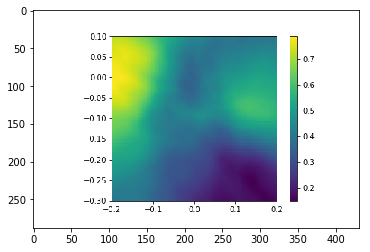

In [5]:
def plot_v():
    res = 100
    min_x, max_x = (-0.2, 0.2)
    min_y, max_y = (-0.3, 0.1)
    x = torch.zeros(res * res, env.env.observation_space.shape[0]).cuda()
    u = torch.zeros(res * res, env.env.action_space.shape[0]).cuda()
    q = torch.zeros(res * res, 1).cuda()
    for row, eef_x in enumerate(np.linspace(min_x, max_x, res)):
        for col, eef_y in enumerate(np.linspace(min_y, max_y, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([eef_x, eef_y, 0.0, 0.0, 0.0, 0.1, 0.0])
    q = critic(x, u)
    q_np = q.cpu().detach().numpy().reshape((res, res))
    plt.imshow(q_np, origin='lower', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar()
    fig = plt.gcf()
    fig.canvas.draw()
    plot_img = np.array(fig.canvas.renderer._renderer)
    plt.close()
    return plot_img
    
def plot_q():
    res = 100
    min_ux, max_ux = (-1.0, 1.0)
    min_uy, max_uy = (-1.0, 1.0)
    x = torch.zeros(res * res, env.env.observation_space.shape[0]).cuda()
    u = torch.zeros(res * res, env.env.action_space.shape[0]).cuda()
    q = torch.zeros(res * res, 1).cuda()
    for row, u_x in enumerate(np.linspace(min_ux, max_ux, res)):
        for col, u_y in enumerate(np.linspace(min_uy, max_uy, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([0.0, -0.25, 0.0, 0.0, 0.0, 0.1, 0.0])
            u[col * res + row, :] = torch.cuda.FloatTensor([u_x, u_y])
    q = critic(x, u)
    π_u = actor(x)[0].cpu().detach().numpy()
    q_np = q.cpu().detach().numpy().reshape((res, res))
    plt.imshow(q_np, origin='lower', extent=[min_ux, max_ux, min_uy, max_uy])
    plt.plot(*π_u, 'ko', markersize=10.0)
    plt.plot(*π_u, 'wo', markersize=8.0)
    plt.colorbar()
    fig = plt.gcf()
    fig.canvas.draw()
    plot_img = np.array(fig.canvas.renderer._renderer)
    plt.close()
    return plot_img
    
    
def plot_actor():
    res = 16
    min_x, max_x = (-0.2, 0.2)
    min_y, max_y = (-0.3, 0.1)
    x = torch.zeros(res * res, env.env.observation_space.shape[0]).cuda()
    for row, eef_x in enumerate(np.linspace(min_x, max_x, res)):
        for col, eef_y in enumerate(np.linspace(min_y, max_y, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([eef_x, eef_y, 0.0, 0.0, 0.0, 0.1, 0.0])
    u = actor(x)
    x = x.cpu().detach().numpy()
    u = u.cpu().detach().numpy()
    k = 0.01
    for u_row, x_row in zip(u, x):
        plt.arrow(x_row[0], x_row[1], k * u_row[0], k * u_row[1])
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    fig = plt.gcf()
    fig.canvas.draw()
    plot_img = np.array(fig.canvas.renderer._renderer)
    plt.close()
    return plot_img
    
plt.imshow(plot_v())

In [6]:
def noise_estimate(x):
    u_no_noise = actor(x)
    parameter_noise.apply()
    u_noise = actor(x)
    parameter_noise.reset()
    d = ((u_noise - u_no_noise) ** 2).mean().sqrt()
    return d

In [10]:
actor.train()
critic.train()

rolling_return = None
best_rolling_return = -np.inf

for epoch in range(nb_epochs):
    for cycle in range(nb_epoch_cycles):
        
        # Rollouts
        parameter_noise.apply()
        rollout(nn_policy, epsilon=0.01, nb_rollout_steps=nb_rollout_steps)
        parameter_noise.reset()
        
        # Train
        for batch_ind, batch in enumerate(dataloader):
            if batch_ind >= nb_train_steps:
                break

            x, u, r, x_ = map(lambda x: x.cuda(), batch)

            # Update parameter noise
            d = noise_estimate(x)
            parameter_noise.feedback(d)

            # update critic
            q_target = r + gamma * norm_q(critic_target(x_, actor_target(x_)))
            q_loss = norm_q.mse_loss(critic(x, u), q_target.detach())
            critic_opt.zero_grad()
            q_loss.backward(retain_graph=True)
            critic_opt.step()

            # update actor
            actor_u = actor(x)
            actor_loss = -critic(x, actor_u).mean() + 0.1 * (actor_u ** 2).mean()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            soft_update(critic_target, critic, 0.001)
            soft_update(actor_target, actor, 0.001)
            
        step = (epoch * nb_epoch_cycles + cycle) * nb_rollout_steps

        logger.add_scalar('q_loss', q_loss, step)
        logger.add_scalar('actor_loss', actor_loss, step)
        
        # Evaluate
        R_eval = rollout(nn_policy,
                         epsilon=0.0,
                         nb_rollout_steps=nb_rollout_steps,
                         render=False,
                         fill_buffer=False)
        if rolling_return is None:
            rolling_return = R_eval
        else:
            rolling_return = 0.8 * rolling_return + 0.2 * R_eval
        if rolling_return > best_rolling_return:
            best_rolling_return = rolling_return
            torch.save(actor.state_dict(), './saved_models/actor.pt')
            torch.save(critic.state_dict(), './saved_models/critic.pt')
            torch.save(norm_q.state_dict(), './saved_models/norm_q.pt')
        logger.add_scalar('rolling_return', rolling_return, step)
        logger.add_scalar('R_eval', R_eval, step)

In [9]:
epoch, cycle

(371, 8)

[ 0.03707972 -0.16927361]
[ 0.03151616 -0.15627235]
[3.335022]
[-0.4933367  0.8698384]


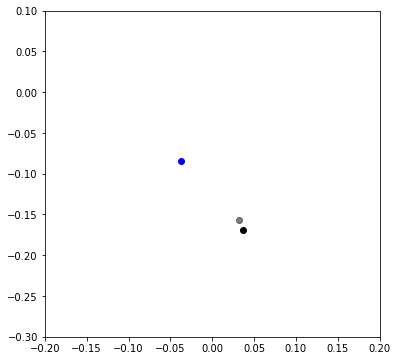

In [29]:
batch = next(iter(dataloader))
x, u, r, x_ = map(lambda x: x.cuda(), batch)

fig = plt.figure(figsize=(6, 6))
i = np.random.randint(0, 128)
x_np = x[i].cpu().numpy()
x_np_ = x_[i].cpu().numpy()
print(x_np[:2])
print(x_np_[:2])
plt.plot(*x_np[:2], 'ko')
plt.plot(*x_np_[:2], 'ko', alpha=0.5)
plt.plot(*x_np[2:4], 'bo')
print(r[i].cpu().detach().numpy())
print(u[i].cpu().detach().numpy())
plt.xlim(-0.2, 0.2)
plt.ylim(-0.3, 0.1)
plt.show()

In [63]:
parameter_noise.apply()
rollout(nn_policy, epsilon=0.01, render=True, fill_buffer=False)
parameter_noise.reset()